In [94]:
import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import copy
import queue

##### Function To Get The Neighbours of a Particular Pixle.

In [95]:
def  find_neighbors(position, map, neighbours_num = 4):
    height, width = map.shape
    y,x = position
    neighbors = []

    if neighbours_num == 4:
        if x-1 >= 0 :
            neighbors.append((position[0],position[1]-1)) # left
            
        if y-1 >= 0:
            neighbors.append((position[0]-1,position[1])) # up

        if x+1 < width:
            neighbors.append((position[0],position[1]+1)) # right
            
        if y+1 < height:
            neighbors.append((position[0]+1,position[1])) # down
    
    elif neighbours_num == 8:
        if x-1 >= 0 :
            neighbors.append((position[0],position[1]-1)) # left
            
        if y-1 >= 0:
            neighbors.append((position[0]-1,position[1])) # up

        if x+1 < width:
            neighbors.append((position[0],position[1]+1)) # right
            
        if y+1 < height:
            neighbors.append((position[0]+1,position[1])) # down

        if x-1 >= 0 and y-1 >= 0:
            neighbors.append((position[0]-1,position[1]-1)) # left up
            
        if y-1 >= 0 and x+1 < width:
            neighbors.append((position[0]-1,position[1]+1)) # right up

        if x+1 < width and y+1 < height:
            neighbors.append((position[0]+1,position[1]+1)) # right down 
            
        if y+1 < height and x-1 >= 0:
            neighbors.append((position[0]+1,position[1]-1)) # left down
        pass
            
    return neighbors 


##### Function to Remove Edges

In [96]:
def remove_edges (map, edge_size = 3):
    
    height, width = map.shape

    map[0:edge_size, :] = 0
    map[width-edge_size:width,:] = 0
    map[:, 0:edge_size] = 0
    map[:,height -edge_size:height] = 0

    return map

##### Bush-Fire Function

In [97]:
def bushfire(map, neighbours_num):
    # Initialize a list of all elements in the map that are equal to 1 (obstacles)
    L = list(np.argwhere(map == 1))

    # Process each cell until there are no more neighbors to visit
    while len(L) != 0:
        # Pop the last element from the list (current cell to process)
        actual = L.pop()
        
        # Find neighboring cells around the current cell
        neighbors = find_neighbors(actual, map, neighbours_num=neighbours_num)
        
        # Update each neighboring cell if it hasn't been assigned a distance
        for neighbor in neighbors:
            y, x = neighbor
            yact, xact = actual
            if map[y][x] == 0:
                map[y][x] = map[yact][xact] + 1  # Increment distance from the obstacle
                L = [(y, x)] + L  # Add new neighbor to the front of the list

    return map


##### Potential Field Function

In [98]:
def get_attraction_function(map, goal, z=1, distance="mht", apply_scaling=True, scale_factor=10):
    
    """
    Define connectivity options for neighboring cells:
    
    8D connectivity:              4D connectivity:
    
    | 1   1   1 |                 | 0   1   0 |
    | 1  goal 1 |                 | 1  goal 1 |
    | 1   1   1 |                 | 0   1   0 |
    """

    # Get dimensions of the map and the goal coordinates
    height, width = map.shape
    ygoal, xgoal = goal
    attraction_grid = np.zeros((height, width))  # Initialize the grid for attraction values

    # Calculate attraction using Euclidean (quadratic) distance
    if distance == "d2":
        """
        Using a quadratic potential function to compute attraction:
            U_att(q) = 1/2 * z * (distance^2 to the goal)
        """
        for i in range(height):
            for j in range(width):
                # Distance based on squared differences in x and y coordinates
                attraction_grid[i][j] = 0.5 * z * ((j - xgoal)**2 + (i - ygoal)**2)

    # Calculate attraction using Manhattan distance
    if distance == "mht":
        """
        Using a Manhattan distance-based potential function:
            U_att(q) = |delta y| + |delta x|
        """
        for i in range(height):
            for j in range(width):
                # Distance based on absolute differences in x and y coordinates
                attraction_grid[i][j] = abs(j - xgoal) + abs(i - ygoal)
    
    # Optionally scale the attraction values
    if apply_scaling:
        attraction_grid = attraction_grid / attraction_grid.max() * scale_factor

    return attraction_grid


##### Repulsive Field Function 

In [99]:
def get_repulsive_function(map, Q=4, eta=15):
    # Get dimensions of the map
    height, width = map.shape

    # Initialize a grid to store repulsive potential values
    repulsive_grid = np.zeros((height, width))
    
    # Iterate through each cell in the map
    for i in range(height):
        for j in range(width):
            # If the cell's distance value is greater than Q, set repulsion to 0 (no repulsion)
            if map[i, j] > Q:
                repulsive_grid[i, j] = 0
            else: 
                # Apply repulsive potential function for cells within the threshold distance Q
                repulsive_grid[i, j] = 0.5 * eta * ((1 / map[i, j]) - (1 / Q))**2

    return repulsive_grid


##### Gradient Descent Function

In [100]:
def get_gradient_descent(map, q_start, neighbours_num=8):
    # Set a threshold for convergence
    E = 0.001
    
    # Initialize starting point coordinates
    y, x = q_start

    # Lists to store the x and y coordinates of the descent path
    gradient_listx = []
    gradient_listy = []

    # Initial difference for gradient descent check
    dq = 100
    
    # Counter to limit iterations and prevent infinite loops
    c = 0
    
    # Continue descent until dq (change in map values) is below the threshold E
    while abs(dq) > E:
        # Find neighboring cells based on the specified neighborhood count
        neighbours = find_neighbors((y, x), map, neighbours_num)
        temp_neig_dq = []

        # Calculate dq for each neighbor relative to the current cell
        for i in neighbours:
            dq = map[i[0], i[1]] - map[y, x]
            temp_neig_dq.append(dq)

        # Get the minimum dq from the neighbors
        dq = min(temp_neig_dq)

        # Move to the neighbor with the smallest dq
        y, x = neighbours[temp_neig_dq.index(dq)]
        
        # Append the new position to the gradient lists
        gradient_listx.append(x)
        gradient_listy.append(y)

        # Break if iteration limit is reached
        if c > 500:
            break

        # Increment the counter
        c += 1

    return gradient_listx, gradient_listy


##### Wave-Front Function

In [101]:
def wave_front(q_goal, n_neighbours, apply_scaling=True):
    # Create a deep copy of the map and initialize it as a float array for the wavefront values
    wave_map = copy.deepcopy(map).astype(float)
    
    # Set initial wavefront value and assign it to the goal cell
    value = 2
    wave_map[q_goal[0], q_goal[1]] = value

    # Initialize a queue to manage cells to update, starting with the goal
    que = queue.SimpleQueue()
    que.put([q_goal])

    # Continue expanding wavefront until there are no more cells to process
    while not que.empty():
        # Increment wavefront value for the next layer
        value += 1
        # Get all neighbors to be updated at the current wavefront value
        all_neigh = que.get()
        valid_neigh = []  # List to collect valid neighbors for the next wavefront expansion

        # Process each cell in the current wavefront layer
        for p in all_neigh:
            # Find neighbors of the current cell
            neigh = [list(t) for t in find_neighbors([*p], wave_map, n_neighbours)]
            
            # Update each neighbor if it hasn’t been visited and is not the goal
            for n in neigh:
                if list(n) != q_goal and wave_map[n[0], n[1]] == 0:
                    wave_map[n[0], n[1]] = value  # Assign wavefront value to neighbor
                    valid_neigh.append(n)  # Add neighbor to the list for next layer

        # Add valid neighbors to the queue for the next iteration
        if len(valid_neigh) != 0:
            que.put(valid_neigh)

    # Set obstacle cells (originally 1) to a high value (max + 1) to signify untraversable areas
    wave_map[np.where(wave_map == 1)] = wave_map.max() + 1

    # Optionally scale wavefront values
    if apply_scaling:
        wave_map = wave_map / wave_map.max() * 200

    return wave_map


##### Path-Finder Function

In [102]:
def find_path(wave_map, q_start, q_goal, neighbours_num):
    pathx = []
    pathy = []

    # Continue until the start point reaches the goal
    while q_start != q_goal:
        # Find the neighbors of the current position
        neigh = find_neighbors(q_start, wave_map, neighbours_num)

        # Select the neighbor with the smallest wavefront value (closer to goal)
        q_start = neigh[np.argmin([wave_map[n] for n in neigh])]

        # Append the new position coordinates to the path lists
        pathx.append(q_start[1])  # x-coordinate
        pathy.append(q_start[0])  # y-coordinate

    return pathx, pathy


### Inputs to the Code

In [103]:
map_number = 0
num_neigbours_used = 8
Q_used = 50
save_path = f"FINAL_RESULTS/map{map_number}"

 
if map_number == 0:
    # goal = (90, 70)
    goal = (110, 40)
    start = (10, 10)
elif map_number == 1:
    goal = (90, 60)
    start = (60, 60)
elif map_number == 2:
    goal = (139, 38)
    start = (8, 31)
elif map_number == 3:
    goal = (375, 375)
    start = (50, 90)

# Load grid map 
image = Image.open('data/map'+str(map_number)+'.png').convert('L')
grid_map = np.array(image.getdata()).reshape(image.size[0], image.size[1])/255
# binarize the image
grid_map[grid_map > 0.5] = 1
grid_map[grid_map <= 0.5] = 0



### **Map without edges**

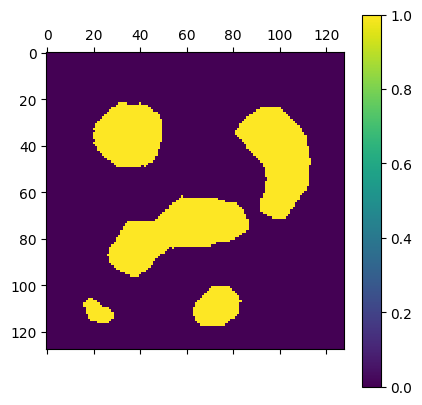

In [104]:
# Invert colors to make 0 -> free and 1 -> occupied
map = (grid_map * -1) + 1
map = remove_edges(map)

plt.matshow(map)
plt.colorbar()
plt.show()


### **PART 1:** Attraction function: Quadratic Potential Function


### Exercise 1:

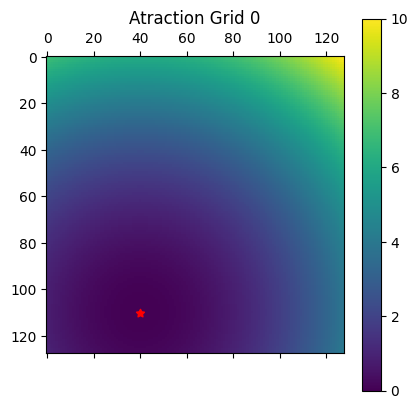

In [105]:

atraction_grid = get_attraction_function(map, goal,distance = "d2")

plt.matshow(atraction_grid)
plt.title(f"Atraction Grid {map_number}")
plt.colorbar()
plt.scatter(goal[1], goal[0], c="r",  marker=(5, 1))
plt.savefig(os.path.join(save_path,f"atraction_grid_{map_number}_n_{num_neigbours_used}.png"))
plt.show()



#### Exercise 2: 

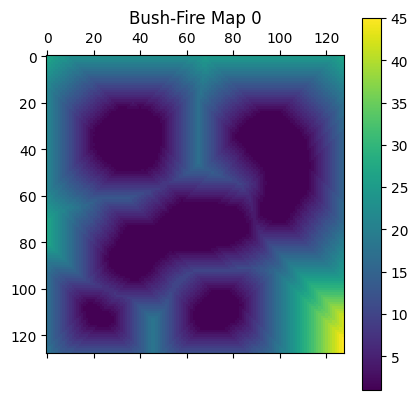

In [106]:
dist_to_obstacle = bushfire(copy.deepcopy(map), neighbours_num=num_neigbours_used)

plt.matshow(dist_to_obstacle)
plt.title(f"Bush-Fire Map {map_number}")
plt.colorbar()
plt.savefig(os.path.join(save_path,f"Bush-Fire_{map_number}_n_{num_neigbours_used}.png"))
plt.show()


#### Exercise 3: 

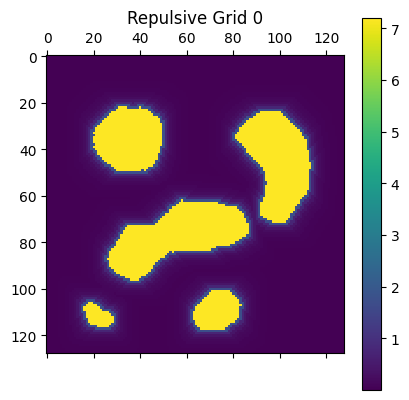

In [107]:

repulsive_grid = get_repulsive_function(dist_to_obstacle, Q = Q_used, eta = 15)

plt.matshow(repulsive_grid)
plt.title(f"Repulsive Grid {map_number}")
plt.colorbar()
plt.savefig(os.path.join(save_path,f"repulsive_grid{map_number}_n_{num_neigbours_used}.png"))
plt.show()


### Exercise 4:

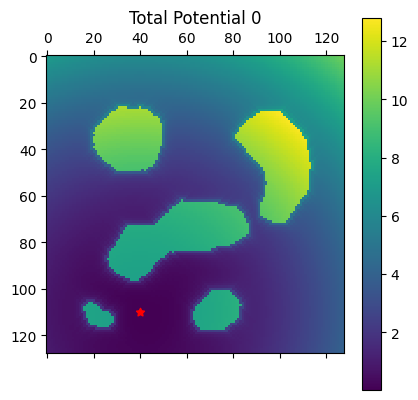

In [108]:

potential = atraction_grid + repulsive_grid

plt.matshow(potential)
plt.title(f"Total Potential {map_number}")
plt.colorbar()
plt.scatter(goal[1], goal[0], c="r",  marker=(5, 1))
plt.savefig(os.path.join(save_path,f"potential_{map_number}_n_{num_neigbours_used}.png"))
plt.show()



### **PART 2:** Gradient Descent

### Exercise 5:

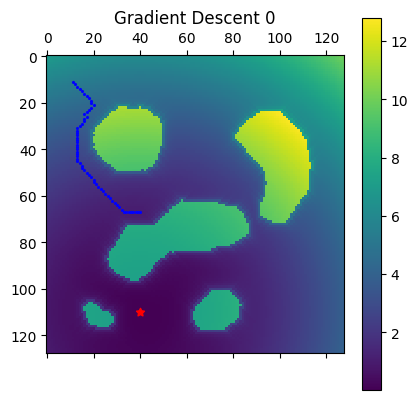

In [109]:

gradient_listx, gradient_listy = get_gradient_descent(potential, start, neighbours_num=num_neigbours_used)

plt.matshow(potential)
plt.title(f"Gradient Descent {map_number}")
plt.colorbar()
plt.scatter(gradient_listx, gradient_listy, s=2, marker = "*", c="b")
plt.scatter(goal[1], goal[0], c="r",  marker=(5, 1))
plt.savefig(os.path.join(save_path,f"gradient_{map_number}_n_{num_neigbours_used}_goal2.png"))
plt.show()


### **PART 3:** Wave-front planner & Path-Finder

### Exercise 6: Wave-front planner 

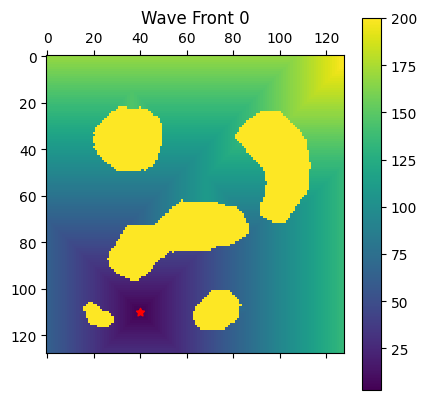

In [110]:
wave_map = wave_front(goal,n_neighbours=num_neigbours_used,apply_scaling=True)

plt.matshow(wave_map)
plt.title(f"Wave Front {map_number}")
plt.colorbar()
plt.scatter(goal[1], goal[0], c="r",  marker=(5, 1))
plt.savefig(os.path.join(save_path,f"wave_map_{map_number}_n_{num_neigbours_used}.png"))
plt.show()


### Exercise 7: Path-Finder

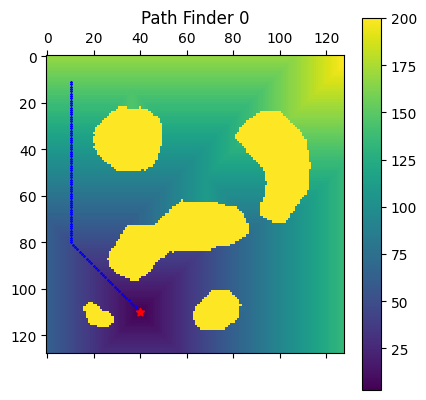

In [111]:
pathx,pathy = find_path(wave_map, start,goal, neighbours_num=num_neigbours_used)

plt.matshow(wave_map)
plt.title(f"Path Finder {map_number}")
plt.colorbar()
plt.scatter(pathx, pathy, s=1, marker = "*", c="b")
plt.scatter(goal[1], goal[0], c="r",  marker=(5, 1))
plt.savefig(os.path.join(save_path,f"path_finder_{map_number}_n{num_neigbours_used}.png"))
plt.show()
